In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import geopandas as gpd
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
import altair as alt
import plotly.express as px
import numpy as np

In [ ]:
london_data = pd.read_csv('london_data_with_greenspace_flag.csv', index_col=0)

## 1. Simple Analysis:

### Questions:
* How many observations are made in greenspaces (for each year)? 
* How is the distribution of greenspaces in london vs. non-greenspaces and then which is the proportion of observations for each of the areas? 
* How many observations per user are made in greenspaces? Can we classify users based on them? 

#### How many observations are made in greenspaces?

In [4]:
london_data.greenspace_flag.value_counts()

0    8235
1    5495
Name: greenspace_flag, dtype: int64

#### Plot the amount of greenspace-observations per year:

In [5]:
london_data['observed_on'] = pd.to_datetime(london_data['observed_on'])

In [6]:
london_data['year'] = pd.DatetimeIndex(london_data['observed_on']).year

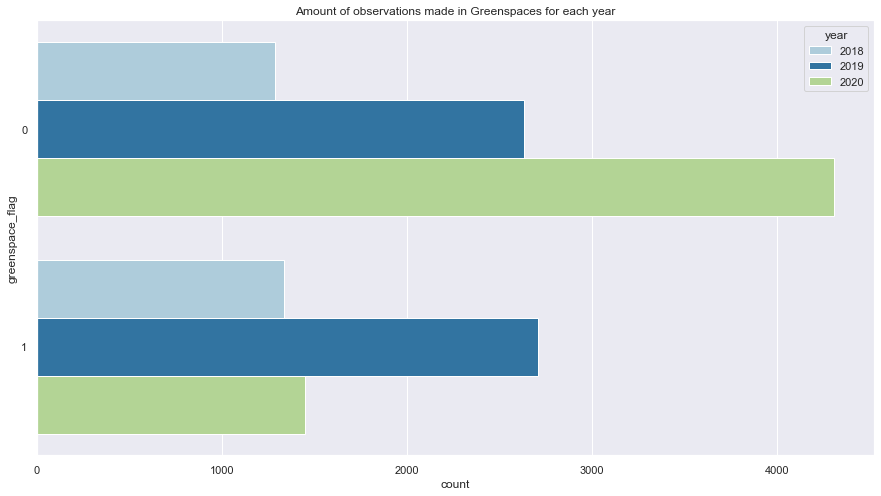

In [8]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,8))
plt.title('Amount of observations made in Greenspaces for each year')
ax = sns.countplot(y="greenspace_flag", hue="year", data=london_data, palette='Paired')

In [9]:
fig = ax.get_figure()
fig.savefig("ldn_greenspace_overview_absolute.png")

In [10]:
grouped_df = london_data.groupby(['year', 'greenspace_flag']).count()['observed_on_string'].to_frame()

In [11]:
grouped_df.reset_index(inplace=True)

In [12]:
grouped_df.head()

,year,greenspace_flag,observed_on_string
0,2018,0,1290
1,2018,1,1334
2,2019,0,2636
3,2019,1,2709
4,2020,0,4309


In [13]:
grouped_df.set_index(['year', 'greenspace_flag'], inplace=True)
grouped_df.head()

observed_on_string
year greenspace_flag                    
2018 0                              1290
     1                              1334
2019 0                              2636
     1                              2709
2020 0                              4309

In [14]:
grouped_df['proportions'] = 0.

In [15]:
for y in grouped_df.index.unique(level='year').tolist():
    grouped_df.at[(y, 0), 'proportions'] = grouped_df.loc[(y, 0), 'observed_on_string'] / (grouped_df.loc[(y, 0), 'observed_on_string'] + grouped_df.loc[(y, 1), 'observed_on_string'])
    grouped_df.at[(y, 1), 'proportions'] = grouped_df.loc[(y, 1), 'observed_on_string'] / (grouped_df.loc[(y, 0), 'observed_on_string'] + grouped_df.loc[(y, 1), 'observed_on_string'])

In [16]:
grouped_df.head()

observed_on_string  proportions
year greenspace_flag                                 
2018 0                              1290     0.491616
     1                              1334     0.508384
2019 0                              2636     0.493171
     1                              2709     0.506829
2020 0                              4309     0.747960

In [17]:
grouped_df.reset_index(inplace=True)

[Text(0.5, 0, 'amount of observations'), Text(0, 0.5, 'greenspace flag')]

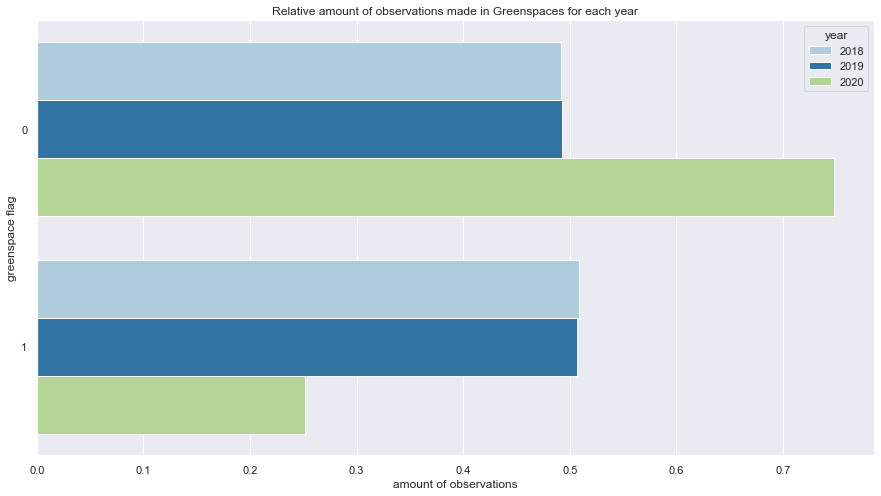

In [18]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,8))
plt.title('Relative amount of observations made in Greenspaces for each year')
ax = sns.barplot(x="proportions", y="greenspace_flag", hue="year", data=grouped_df, palette='Paired', orient='h')
ax.set(xlabel='amount of observations', ylabel='greenspace flag')

In [19]:
fig = ax.get_figure()
fig.savefig("ldn_greenspace_overview_relative.png")

### 1.1. 2018:

#### How many observations per users are made in greenspaces?

In [ ]:
# 2018: 
london_2018 = london_data[london_data.year == 2018]

In [22]:
len(london_2018.user_login.unique())

109

Since we have 109 different users, which we won't be able to put into one plot, let's first search for the top-20 users (based on the amount of observations they did) and plot them.

In [ ]:
# select the top-20 users: 
ranks = london_2018.groupby('user_login').count()['year'].to_frame()
ranks.rename(columns={'year':'num_obsverations'}, inplace=True)
ranks.head()

In [24]:
ranks.reset_index(inplace=True)
ranks.columns

Index(['user_login', 'num_obsverations'], dtype='object')

In [25]:
ranks.sort_values(by='num_obsverations', inplace=True, ascending=False)

In [ ]:
ranks.head()

In [27]:
top_20 = ranks.head(20)

In [ ]:
top_20_users = top_20.user_login.values.tolist()
top_20_users

In [ ]:
london_top_20 = london_2018[london_2018['user_login'].isin(top_20_users)]
london_top_20.head()

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Amount of observations made in greenspaces and non-greenspaces per user')
ax = sns.countplot(y="greenspace_flag", hue="user_login", data=london_top_20, palette='Spectral')

#### Plot the proportion of observation-locations for the top-20 users: 

In [31]:
proportion_df = london_top_20.groupby(['user_login', 'greenspace_flag']).size().to_frame()

In [ ]:
proportion_df.head()

In [ ]:
proportion_df.reset_index(inplace=True)
proportion_df.head()

In [ ]:
proportion_df.rename(columns={0: 'num_observations'}, inplace=True)
proportion_df.head()

In [35]:
proportion_df['proportion'] = 0
proportion_df.set_index(['user_login', 'greenspace_flag'], inplace=True)

In [ ]:
for user in proportion_df.index.unique(level='user_login'):
    print(user)
    if (user, 1) in proportion_df.index.unique() and (user, 0) in proportion_df.index.unique():
        proportion_df.loc[user, 'proportion'] = proportion_df.loc[(user, 1), 'num_observations'] / (proportion_df.loc[(user, 1), 'num_observations'] + proportion_df.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in proportion_df.index.unique(): 
        proportion_df.loc[user, 'proportion'] = 1.0

In [ ]:
proportion_df.head()

In [ ]:
proportion_df['num_obs'] = 0
for user in proportion_df.index.unique(level='user_login'):
    print(user)
    if (user, 1) in proportion_df.index.unique() and (user, 0) in proportion_df.index.unique():
        proportion_df.loc[user, 'num_obs'] = proportion_df.loc[(user, 1), 'num_observations'] + proportion_df.loc[(user, 0), 'num_observations']
    elif (user, 0) not in proportion_df.index.unique() and (user, 1) in proportion_df.index.unique(): 
        proportion_df.loc[user, 'num_obs'] = proportion_df.loc[(user, 1), 'num_observations']
    elif (user, 0) in proportion_df.index.unique() and (user, 1) not in proportion_df.index.unique(): 
        proportion_df.loc[user, 'num_obs'] = proportion_df.loc[(user, 0), 'num_observations']

In [ ]:
proportion_df.head()

In [40]:
proportion_df.reset_index(inplace=True)

In [ ]:
new_df = proportion_df.drop(columns=['greenspace_flag', 'num_observations'])
new_df.head()

In [42]:
len(proportion_df)

37

In [43]:
new_df.drop_duplicates(inplace=True)
len(new_df)

20

#### Is there any correlation between the proportion of greenspace-observations and the amount of observations a user makes?

In [44]:
corr = new_df[['proportion', 'num_obs']].corr()

<AxesSubplot:>

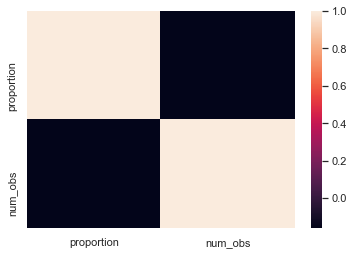

In [45]:
sns.heatmap(corr)

There's obviously no correlation at all.

#### Plot proportions per user:

In [ ]:
plt.figure(figsize=(20,8))
plt.title('Proportion of observations made in greenspace per every user of top-20 users')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_df, palette='Spectral')

#### Plot proportions for all users, not just the top-20: 

In [ ]:
all_proportions_18 = london_2018.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_18.reset_index(inplace=True)
all_proportions_18.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_18['proportion'] = 0
all_proportions_18.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_18.index.unique(level='user_login'):
    print(user)
    if (user, 1) in all_proportions_18.index.unique() and (user, 0) in all_proportions_18.index.unique():
        all_proportions_18.loc[user, 'proportion'] = all_proportions_18.loc[(user, 1), 'num_observations'] / (all_proportions_18.loc[(user, 1), 'num_observations'] + all_proportions_18.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_18.index.unique(): 
        all_proportions_18.loc[user, 'proportion'] = 1.0
        
all_proportions_18.head()

In [ ]:
all_proportions_18.reset_index(inplace=True)
new_proportions_18 = all_proportions_18.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_18.drop_duplicates(inplace=True)
new_proportions_18.head()

In [ ]:
plt.figure(figsize=(35, 8))
plt.title('Proportion of observations made in greenspace per user')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_proportions_18, palette='Spectral')
ax.axhline(0.75)

### 1.2. Do the same analysis for 2019 and 2020:

#### 2019:

In [ ]:
london_19 = london_data[london_data.year == 2019]
all_proportions_19 = london_19.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_19.reset_index(inplace=True)
all_proportions_19.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_19['proportion'] = 0
all_proportions_19.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_19.index.unique(level='user_login'):
    if (user, 1) in all_proportions_19.index.unique() and (user, 0) in all_proportions_19.index.unique():
        all_proportions_19.loc[user, 'proportion'] = all_proportions_19.loc[(user, 1), 'num_observations'] / (all_proportions_19.loc[(user, 1), 'num_observations'] + all_proportions_19.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_19.index.unique(): 
        all_proportions_19.loc[user, 'proportion'] = 1.0
        
all_proportions_19.head()

In [ ]:
all_proportions_19.reset_index(inplace=True)
new_proportions_19 = all_proportions_19.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_19.drop_duplicates(inplace=True)
new_proportions_19.head()

In [ ]:
plt.figure(figsize=(35, 8))
plt.title('Proportion of observations made in greenspace per user')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_proportions_19, palette='Spectral')
ax.axhline(0.75)

#### 2020:

In [ ]:
london_20 = london_data[london_data.year == 2020]
all_proportions_20 = london_20.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_20.reset_index(inplace=True)
all_proportions_20.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_20['proportion'] = 0
all_proportions_20.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_20.index.unique(level='user_login'):
    if (user, 1) in all_proportions_20.index.unique() and (user, 0) in all_proportions_20.index.unique():
        all_proportions_20.loc[user, 'proportion'] = all_proportions_20.loc[(user, 1), 'num_observations'] / (all_proportions_20.loc[(user, 1), 'num_observations'] + all_proportions_20.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_20.index.unique(): 
        all_proportions_20.loc[user, 'proportion'] = 1.0
        
all_proportions_20.head()

In [ ]:
all_proportions_20.reset_index(inplace=True)
new_proportions_20 = all_proportions_20.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_20.drop_duplicates(inplace=True)
new_proportions_20.head()

In [ ]:
plt.figure(figsize=(35, 8))
plt.title('Proportion of observations made in greenspace per user')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_proportions_20, palette='Spectral')
ax.axhline(0.75)

### 1.3. Plot the amount of users whose proportion is above 75% for every year: 

In [57]:
len(new_proportions_20[new_proportions_20.proportion > 0.75]), len(new_proportions_19[new_proportions_19.proportion > 0.75]), len(new_proportions_18[new_proportions_18.proportion > 0.75])

(94, 108, 39)

In [58]:
proportions = [len(new_proportions_18[new_proportions_18.proportion > 0.75]), len(new_proportions_19[new_proportions_19.proportion > 0.75]), len(new_proportions_20[new_proportions_20.proportion > 0.75])]
years = [2018, 2019, 2020]

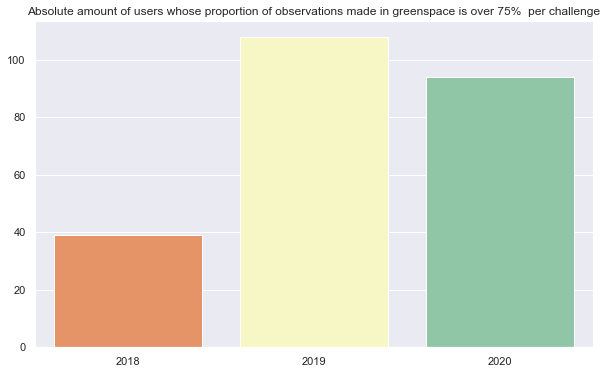

In [59]:
plt.figure(figsize=(10, 6))
plt.title('Absolute amount of users whose proportion of observations made in greenspace is over 75%  per challenge')
ax = sns.barplot(x=years, y=proportions, palette='Spectral')

In [60]:
proportions = [len(new_proportions_18[new_proportions_18.proportion > 0.75])/len(new_proportions_18), 
               len(new_proportions_19[new_proportions_19.proportion > 0.75])/len(new_proportions_19), 
               len(new_proportions_20[new_proportions_20.proportion > 0.75])/len(new_proportions_20)]

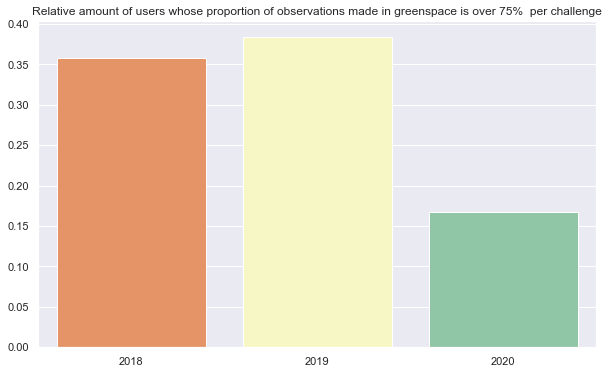

In [61]:
## also relatively compared to the total amount of users in this year 
plt.figure(figsize=(10, 6))
plt.title('Relative amount of users whose proportion of observations made in greenspace is over 75%  per challenge')
ax = sns.barplot(x=years, y=proportions, palette='Spectral')

In [62]:
fig = ax.get_figure()
fig.savefig("ldn_greenspace_proportion.png")

In [64]:
prop = pd.DataFrame(list(zip(years, proportions)), columns=['year', 'proportion'])

In [66]:
prop['city'] = 'London'
prop

,year,proportion,city
0,2018,0.357798,London
1,2019,0.384342,London
2,2020,0.167558,London


In [67]:
prop.to_csv('london_proportions.csv')

### Check whether greenspaces are kind of correlated with some events

In [34]:
greenspace_by_date = london_data.groupby(['observed_on'])['greenspace_flag'].value_counts().to_frame()

In [35]:
greenspace_by_date.head()

greenspace_flag
observed_on greenspace_flag                 
2018-04-27  0                            225
            1                             84
2018-04-28  0                            510
            1                            186
2018-04-29  1                            976

In [36]:
greenspace_by_date.rename(columns={'greenspace_flag':'counts'}, inplace=True)
greenspace_by_date.reset_index(inplace=True)
greenspace_by_date.head()

,observed_on,greenspace_flag,counts
0,2018-04-27,0,225
1,2018-04-27,1,84
2,2018-04-28,0,510
3,2018-04-28,1,186
4,2018-04-29,1,976


In [37]:
greenspace_by_date['observed_on'] = greenspace_by_date['observed_on'].dt.strftime('%Y-%m-%d')

[Text(0, 0, '2018-04-27'),
 Text(1, 0, '2018-04-28'),
 Text(2, 0, '2018-04-29'),
 Text(3, 0, '2018-04-30'),
 Text(4, 0, '2019-04-26'),
 Text(5, 0, '2019-04-27'),
 Text(6, 0, '2019-04-28'),
 Text(7, 0, '2019-04-29'),
 Text(8, 0, '2020-04-24'),
 Text(9, 0, '2020-04-25'),
 Text(10, 0, '2020-04-26'),
 Text(11, 0, '2020-04-27')]

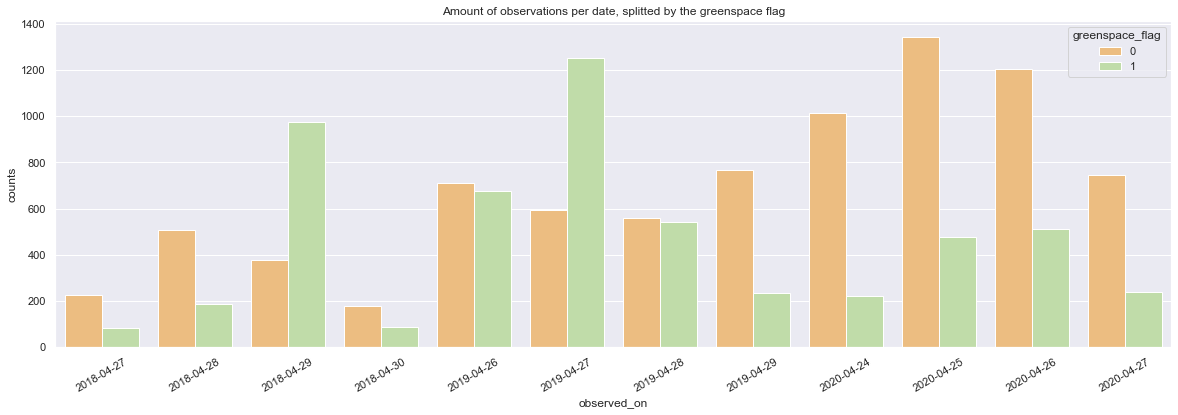

In [32]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20, 6))
plt.title('Amount of observations per date, splitted by the greenspace flag')
ax = sns.barplot(x='observed_on', y='counts', hue='greenspace_flag', data=greenspace_by_date, palette='Spectral')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

Now with relative amounts:

In [38]:
greenspace_by_date.set_index(['observed_on', 'greenspace_flag'], inplace=True)

In [41]:
for date in greenspace_by_date.index.unique(level='observed_on'):
    if (date, 1) in greenspace_by_date.index.unique() and (date, 0) in greenspace_by_date.index.unique():
        greenspace_by_date.loc[(date, 0), 'proportion'] = greenspace_by_date.loc[(date, 0), 'counts'] / (greenspace_by_date.loc[(date, 1), 'counts'] + greenspace_by_date.loc[(date, 0), 'counts'])
        greenspace_by_date.loc[(date, 1), 'proportion'] = greenspace_by_date.loc[(date, 1), 'counts'] / (greenspace_by_date.loc[(date, 1), 'counts'] + greenspace_by_date.loc[(date, 0), 'counts'])

In [42]:
greenspace_by_date.head()

counts  proportion
observed_on greenspace_flag                    
2018-04-27  0                   225    0.728155
            1                    84    0.271845
2018-04-28  0                   510    0.732759
            1                   186    0.267241
2018-04-29  1                   976    0.721893

In [44]:
greenspace_by_date.reset_index(inplace=True)

[Text(0, 0, '2018-04-27'),
 Text(1, 0, '2018-04-28'),
 Text(2, 0, '2018-04-29'),
 Text(3, 0, '2018-04-30'),
 Text(4, 0, '2019-04-26'),
 Text(5, 0, '2019-04-27'),
 Text(6, 0, '2019-04-28'),
 Text(7, 0, '2019-04-29'),
 Text(8, 0, '2020-04-24'),
 Text(9, 0, '2020-04-25'),
 Text(10, 0, '2020-04-26'),
 Text(11, 0, '2020-04-27')]

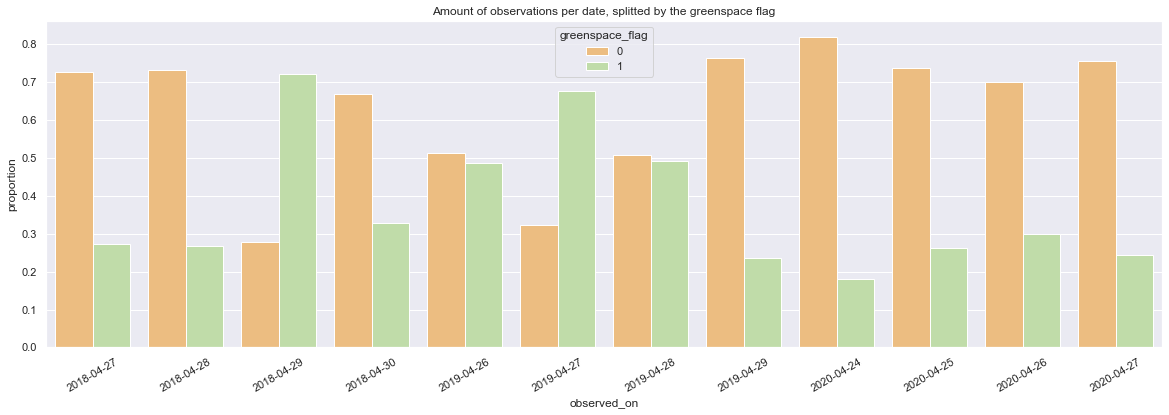

In [45]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20, 6))
plt.title('Amount of observations per date, splitted by the greenspace flag')
ax = sns.barplot(x='observed_on', y='proportion', hue='greenspace_flag', data=greenspace_by_date, palette='Spectral')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

Super nice, there really was an event on the 29.04.18 in Hyde Park, which probably drove people to do most observations in greenspaces: http://togetherscience.eu/blog/city-nature-challenge.